# ML Term Project: "Storm Surge Prediction Using Different Machine Learning Methods"

<br>

**Author:** Javed Ali

### Table of Contents

* [Import Libraries](#importlibraries)
* [Data Preprocessing](#datapreprocessing)
    * [Data cleaning, feature selection and creating time lagging predictors data](#data1)
    * [Data preparation (predictor and predictand data)](#data2)
    * [Splitting the data into training and testing datasets](#data3)
    * [Standardizing the training and testing datasets](#data4)
* [Autocorrelation](#autocorr)
* [Multi-Layer Perceptron (MLP)](#mlp)
    * [Building a MLP model, Training the model, Model evaluation and Plotting the results](#mlp2)
    * [MLP Hyperparameter Tuning](#mlp3)
* [Long Short-Term Memory Networks (LSTM)](#lstm)
    * [Building LSTM model, Data preparation, Training the model, Model evaluation and Plotting the results](#lstm2)
* [Auto Regressive Integrated Moving Average (ARIMA)](#arima)
* [Convolutional Neural Networks (CNN)](#cnn)

### Import all required libraries 

<a class="anchor" id="importlibraries"></a>

In [1]:
# data wrangling and analysis
import pandas as pd 
import numpy as np 
import netCDF4 as nc
from netCDF4 import Dataset

# visualization
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
import seaborn as sns
import mpl_toolkits
%matplotlib inline

# machine learning 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.decomposition import PCA
from keras.layers import Dense, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
import tensorflow as tf
from sklearn import preprocessing
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from statsmodels.tsa.arima_model import ARIMA

# other
import warnings
warnings.filterwarnings("ignore")
import datetime
import time
import math

## 1. Data processing (data preprocessing, data cleaning, feature extraction, feature selection) 
<a class="anchor" id="datapreprocessing"></a>

In [2]:
# load the data
data_cuxhaven = pd.read_csv("Data/cuxhaven_de.csv")

# rename the columns
data_cuxhaven.columns = ['time', 'wind_u10', 'wind_v10', 'slp', 'weight', 'surge']

In [3]:
data_cuxhaven.head()

,time,wind_u10,wind_v10,slp,weight,surge
0,973008,9.304976,0.647637,101466.523656,1.000000,0.040876
1,973008,11.284721,0.234706,101549.947853,0.925527,0.040876
2,973008,9.304976,1.105641,101377.553920,0.668373,0.040876
3,973008,7.498699,1.067838,101748.381707,0.654728,0.040876
4,973008,7.834623,0.971875,101808.900417,0.624854,0.040876


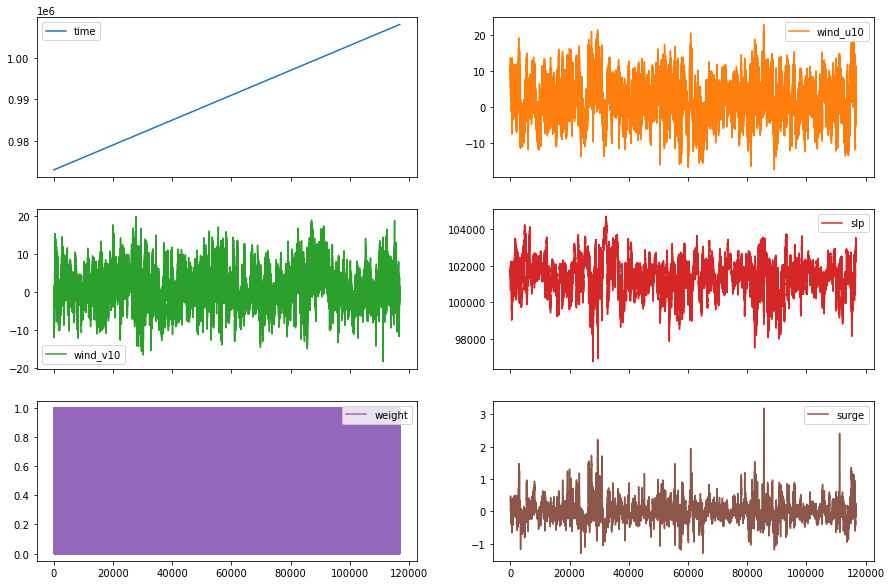

In [15]:
# plot the data
data_cuxhaven.plot(subplots=True, layout=(3, 2), figsize=(15,10))

plt.show()

In [19]:
# checking missing values
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [20]:
missing_percentage(data_cuxhaven)

,Total,Percent
time,0,0.0
wind_u10,0,0.0
wind_v10,0,0.0
slp,0,0.0
weight,0,0.0
surge,0,0.0


### Data cleaning, feature selection and creating time lagging predictors data 
<a class="anchor" id="data1"></a>

In [21]:
# build a function for creating time lagged time series data
def time_lag(data, lags):
    """
    Transforms the dataset to  a time series of grid information and spits back the time lagged time series
    data - the full name of the csv file
    """
    time_orig = pd.to_datetime('1900-01-01')

    df = pd.read_csv(data)
    df.columns = ['time', 'wind_u10', 'wind_v10', 'slp', 'weight', 'surge'] 
    
    # reorganize the matrix
    df_new = df.loc[df['weight'] == df['weight'].unique()[0]]
    df_new.drop(['weight'], axis = 1, inplace=True) #, 'surge'
    
    for i in range(1,10):
        df_sub = df.loc[df['weight'] == df['weight'].unique()[i]]
        df_sub.drop(['weight', 'surge'], axis = 1, inplace=True)
        df_new = pd.merge(df_new, df_sub, on='time')
    
    
    # lag the time series data
    lagged_df = df_new.copy() # to prevent modifying original matrix
    for j in range(lags):
        #lagged.drop(j, axis = 0, inplace = True)
        lagged_df['time'] = lagged_df['time'] + 6
        
        # remove the last row since there is no match for it in df_new
        lagged_df.drop(lagged_df.tail(1).index.item(), axis = 0, inplace = True)
        
        # remove the topmost row from df_new to match lagged
        df_new.drop(df_new.head(1).index.item(), axis = 0, inplace = True)
        
        # merge lagged data with df_new
        df_new = pd.merge(df_new, lagged_df, on = 'time', how = 'outer', \
                       suffixes = ('_left', '_right'))
    df_new = df_new.T.reset_index(drop=True).T
    ind = df_new.loc[pd.isna(df_new[df_new.shape[1]-1]), :].index
    df_new.drop(ind, inplace=True)
    
    # storm surge time series data
    surge_ts = pd.DataFrame(df.loc[df['weight'] == \
                                df['weight'].unique()[0]][['time', 'surge']])
    # remove missing/NaN values
    surge_ts.reset_index(inplace=True) # reset index for subsetting isnans
    surge_ts.drop(['index'], axis = 1, inplace=True)    
    indx = surge_ts.loc[pd.isna(surge_ts["surge"]), :].index
    df_new.drop(indx, inplace=True)
    surge_ts.drop(indx, inplace=True)
    
    # filter surge according to df_new
    lagged_time = list(df_new[0])
    time_df_new = [float(x) for x in df_new[0]]
    time_surge_ts = [float(x) for x in surge_ts['time']]
    time_both = []
    for k in lagged_time:
        if ((k in time_df_new) & (k in time_surge_ts)):
            time_both.append(int(k))
            
    surge_ts = surge_ts[surge_ts['time'].isin(time_both)]
    
    dt = pd.DataFrame(columns = ['date']);
    for i in surge_ts.index:
        dt.loc[i, 'date'] = time_orig + \
            datetime.timedelta(hours = int(surge_ts.loc[i, 'time']))
            
    surge_ts['date'] = dt
    df_new = df_new[df_new[0].isin([x*1.0 for x in time_both])]
    df_new.drop(4, axis = 1, inplace = True) # remove the un-lagged surge data
    return df_new, surge_ts


### Data preparation (predictor and predictand data) 
<a class="anchor" id="data2"></a>

In [22]:
data = 'Data/cuxhaven_de.csv'
x, surge = time_lag(data, 5)

In [23]:
print(x)

            0         1         2              3         5         6    \
0      973038.0  3.016050 -3.749202  101652.419770  4.164247 -6.533576   
1      973044.0  3.787021 -3.592172  101777.797176  4.953116 -5.853113   
2      973050.0  2.587885 -2.344656  101853.264729  3.237704 -4.876038   
3      973056.0  2.210660 -2.074216  101987.804329  2.875623 -4.002195   
4      973062.0  2.441951 -0.915393  102017.702018  3.123435 -2.213798   
...         ...       ...       ...            ...       ...       ...   
5834  1008042.0  3.226690  0.178001  102921.383778  4.326702 -0.628958   
5835  1008048.0  4.420320 -0.333800  102856.283971  5.977407 -1.312330   
5836  1008054.0  4.255111 -1.222183  102862.552842  5.304184 -1.989885   
5837  1008060.0  5.181654 -0.467566  103017.586826  6.640993 -0.053182   
5838  1008066.0  6.102690  1.496762  103088.232171  8.220109  2.276096   

                7         8         9              10   ...            177  \
0     101739.219512  2.696647 -2.

In [24]:
print(surge)

         time     surge                 date
5      973038 -0.173340  2011-01-02 06:00:00
6      973044  0.022045  2011-01-02 12:00:00
7      973050 -0.243710  2011-01-02 18:00:00
8      973056 -0.061471  2011-01-03 00:00:00
9      973062 -0.380670  2011-01-03 06:00:00
...       ...       ...                  ...
5839  1008042  0.098466  2014-12-30 18:00:00
5840  1008048  0.056440  2014-12-31 00:00:00
5841  1008054  0.243050  2014-12-31 06:00:00
5842  1008060  0.119040  2014-12-31 12:00:00
5843  1008066  0.189340  2014-12-31 18:00:00

[5839 rows x 3 columns]


### Splitting the data into training and testing datasets 
<a class="anchor" id="data3"></a>

In [25]:
# split the data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, surge, shuffle=False, test_size=0.20, random_state=42)

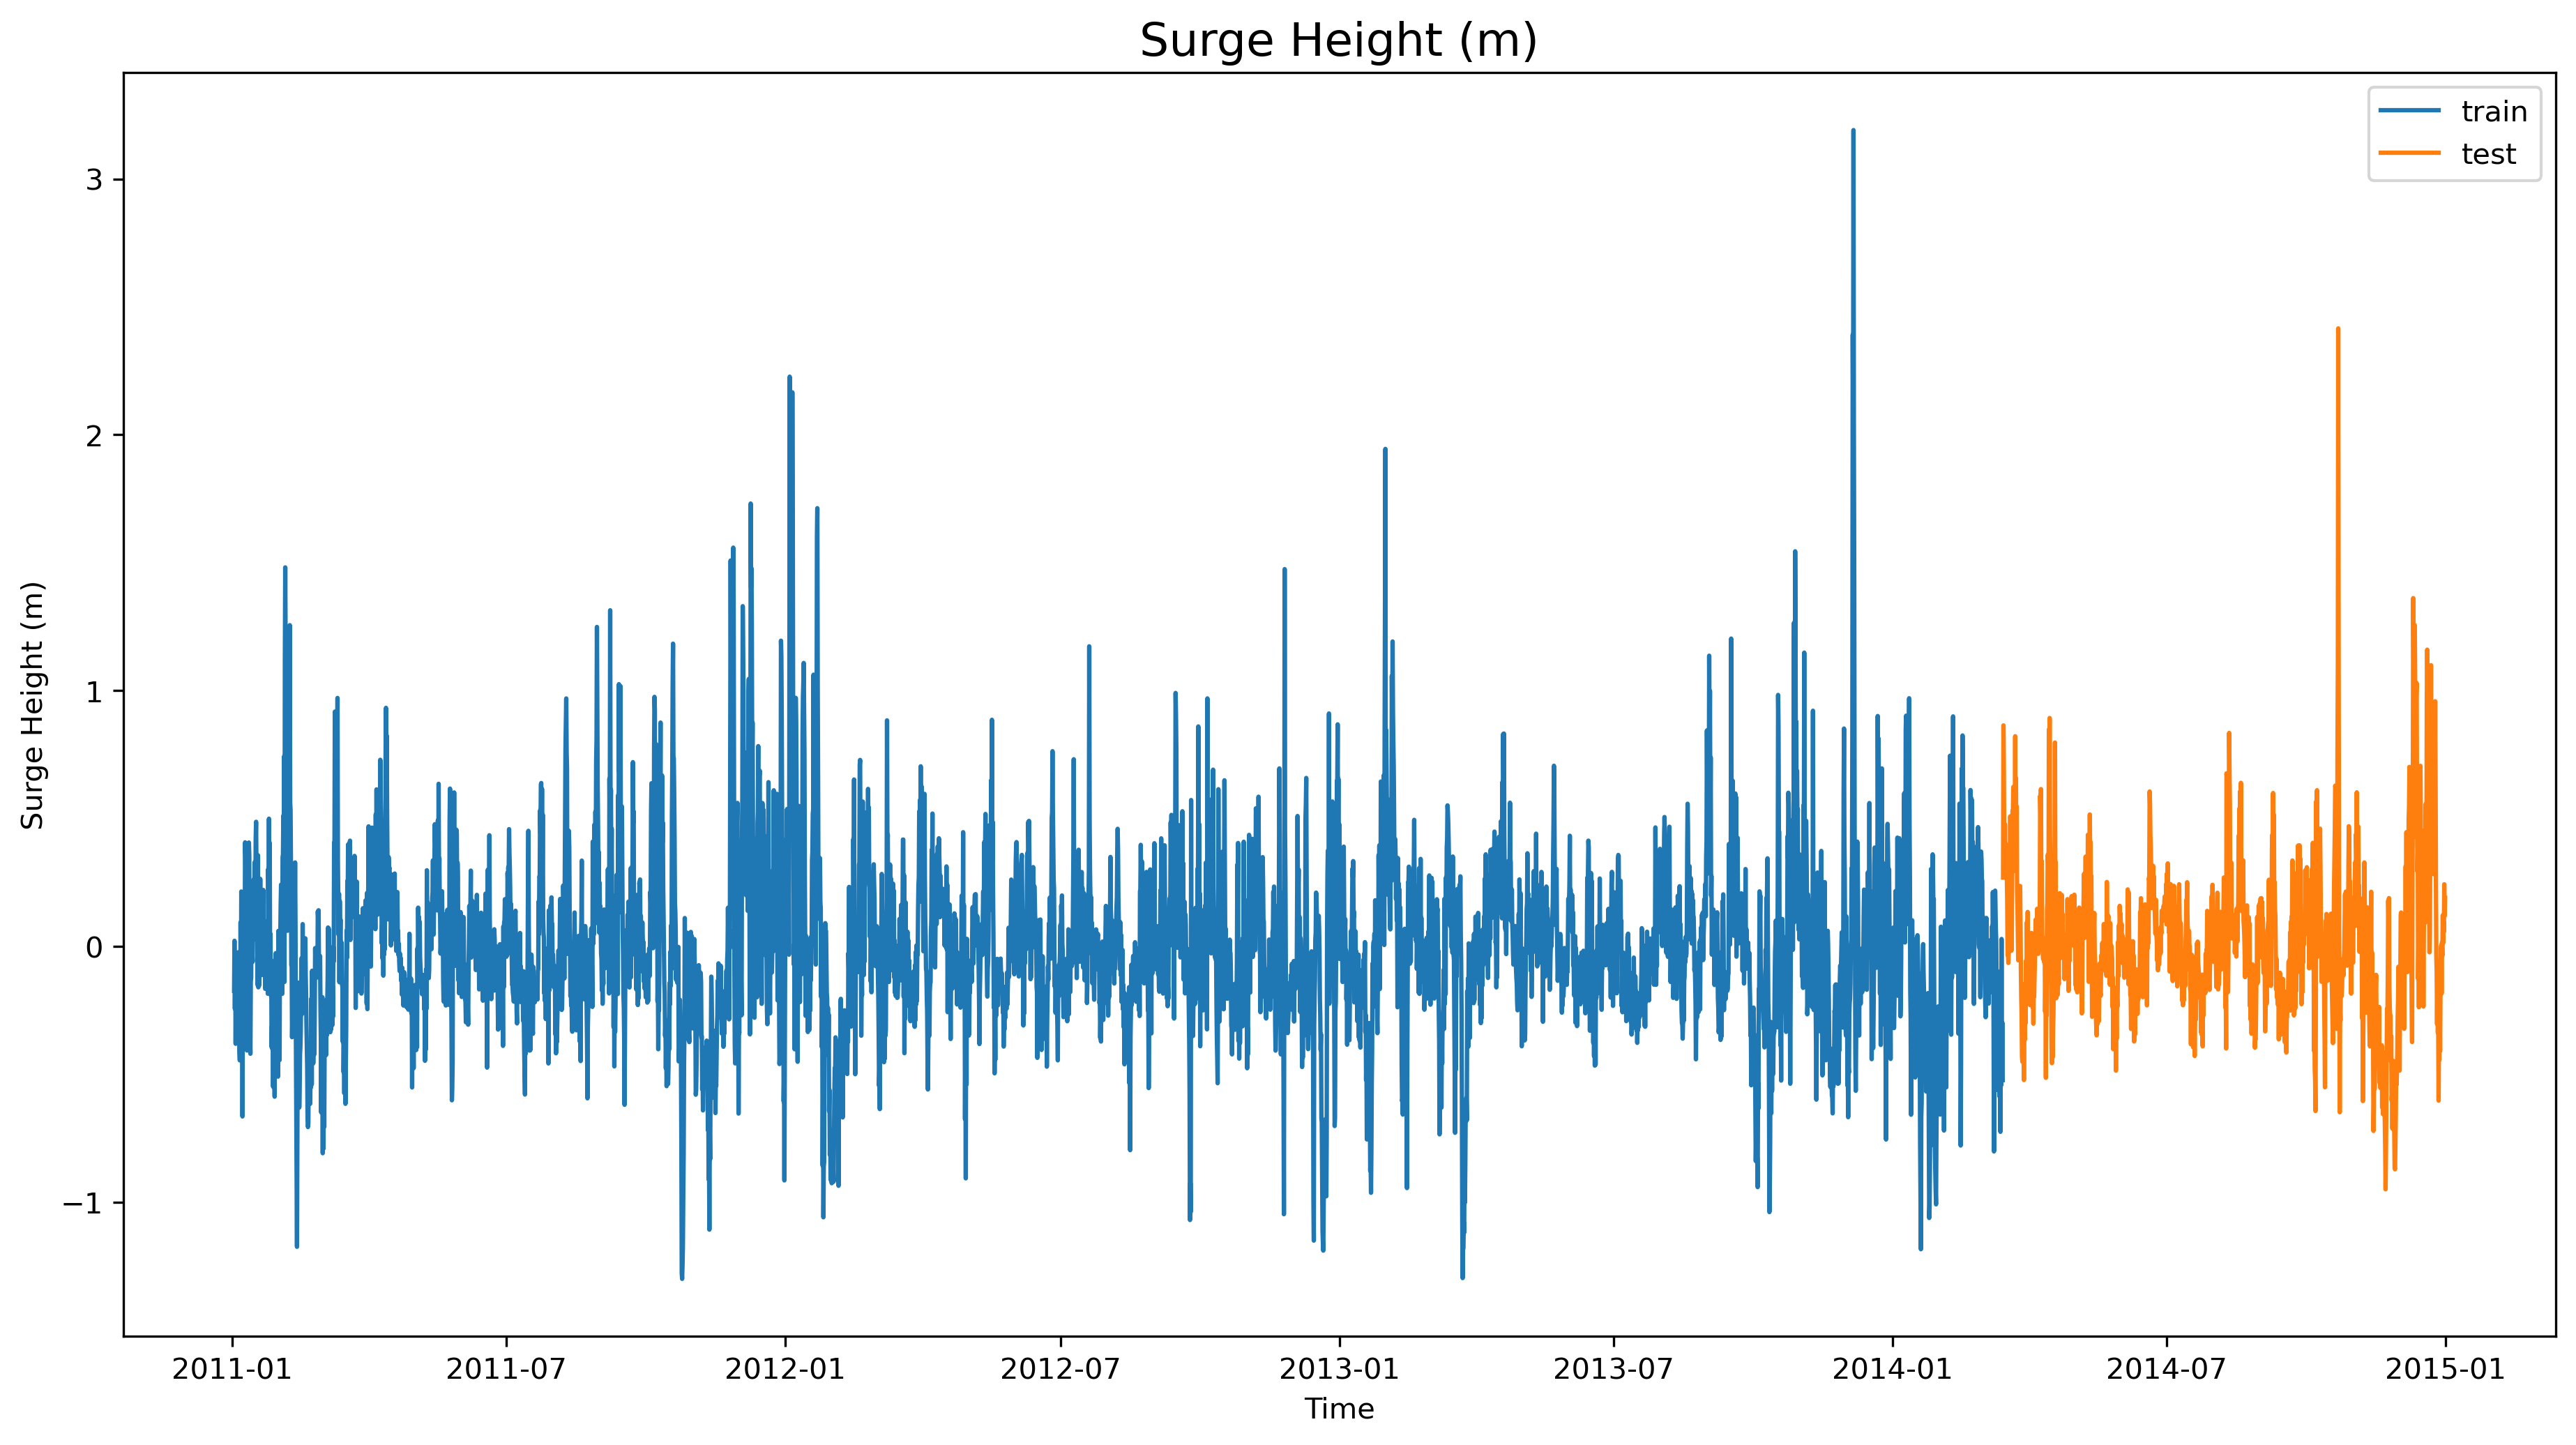

In [41]:
# visualize train and test values for reference
fig = plt.subplots(figsize=(15,8), dpi=300)
plt.plot(y_train.date, y_train.surge, label="train")
plt.plot(y_test.date, y_test.surge, label="test")
plt.title("Surge Height (m)", fontsize=16)
plt.xlabel('Time')
plt.ylabel('Surge Height (m)')
plt.legend(loc='best')
plt.show()

In [34]:
x_train.shape

(4671, 186)

In [35]:
x_test.shape

(1168, 186)

In [36]:
x.shape

(5839, 186)

In [37]:
surge.shape

(5839, 3)

In [38]:
y_train.shape

(4671, 3)

In [39]:
y_test.shape

(1168, 3)

### Standardizing the training and testing datasets 
<a class="anchor" id="data4"></a>

In [42]:
x_norm_train = preprocessing.scale(x_train)
x_norm_test = preprocessing.scale(x_test)

In [43]:
print(x_norm_train)

[[-1.73168004  0.42167951 -1.53336619 ...  1.64670587 -0.08773406
   0.39835794]
 [-1.73093842  0.61715977 -1.48225843 ...  1.39552918 -1.16409738
   0.0812966 ]
 [-1.7301968   0.31311816 -1.07623574 ...  0.98069269 -1.68641603
   0.21079009]
 ...
 [ 1.7301968  -0.1207782  -0.75491941 ... -0.90771374  0.1645265
   1.61717828]
 [ 1.73093842  0.42342487  0.27244105 ... -0.47170891 -0.10591849
   1.4441908 ]
 [ 1.73168004  1.32193591  0.91412727 ...  0.02085017 -0.50133305
   1.43183456]]


In [44]:
print(y_test)

         time     surge                 date
4676  1001064  0.269050  2014-03-15 00:00:00
4677  1001070  0.863970  2014-03-15 06:00:00
4678  1001076  0.715220  2014-03-15 12:00:00
4679  1001082  0.411040  2014-03-15 18:00:00
4680  1001088  0.337190  2014-03-16 00:00:00
...       ...       ...                  ...
5839  1008042  0.098466  2014-12-30 18:00:00
5840  1008048  0.056440  2014-12-31 00:00:00
5841  1008054  0.243050  2014-12-31 06:00:00
5842  1008060  0.119040  2014-12-31 12:00:00
5843  1008066  0.189340  2014-12-31 18:00:00

[1168 rows x 3 columns]


In [45]:
print(y_train)

         time     surge                 date
5      973038 -0.173340  2011-01-02 06:00:00
6      973044  0.022045  2011-01-02 12:00:00
7      973050 -0.243710  2011-01-02 18:00:00
8      973056 -0.061471  2011-01-03 00:00:00
9      973062 -0.380670  2011-01-03 06:00:00
...       ...       ...                  ...
4671  1001034 -0.542870  2014-03-13 18:00:00
4672  1001040  0.029064  2014-03-14 00:00:00
4673  1001046 -0.525450  2014-03-14 06:00:00
4674  1001052 -0.297770  2014-03-14 12:00:00
4675  1001058 -0.522620  2014-03-14 18:00:00

[4671 rows x 3 columns]


## 2. Autocorrelation 
<a class="anchor" id="autocorr"></a>

In [21]:
# create a function for plotting autocorrelations 

def autcorrplt(data, lag, title, *args):
    """
    plots the autocorrelation of a pandas series object
    """
    acorr = [];
    for i in range(lag+1):
        acorr.append(data.autocorr(lag = i))
    
    plt.figure(figsize = (8, 6))
    plt.plot(acorr)
    plt.xlabel("Lag (in 6 hrs)", fontsize = 12)
    plt.ylabel("Correlation", fontsize = 12)
    plt.ylim([0, 1])
    plt.xlim([1, lag])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title(f"Autocorrelation in {title}", fontsize = 16, y=1.03)
    plt.savefig(f"Autocorrelation in {title}.png", dpi=300)

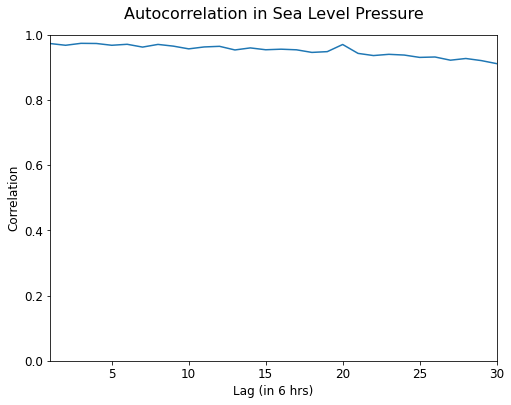

In [22]:
autcorrplt(data_cuxhaven['slp'], 30, "Sea Level Pressure")

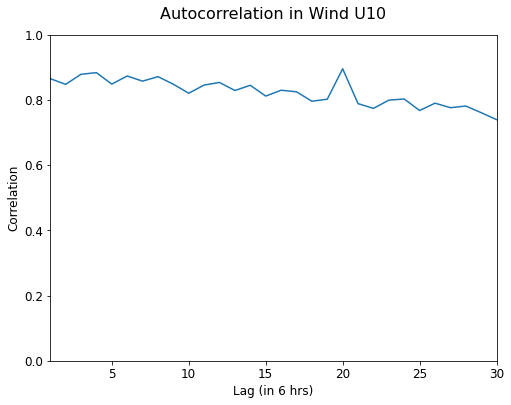

In [23]:
autcorrplt(data_cuxhaven['wind_u10'], 30, "Wind U10")

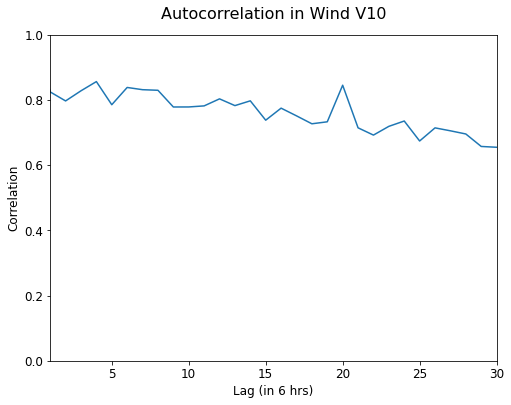

In [24]:
autcorrplt(data_cuxhaven['wind_v10'], 30, "Wind V10")

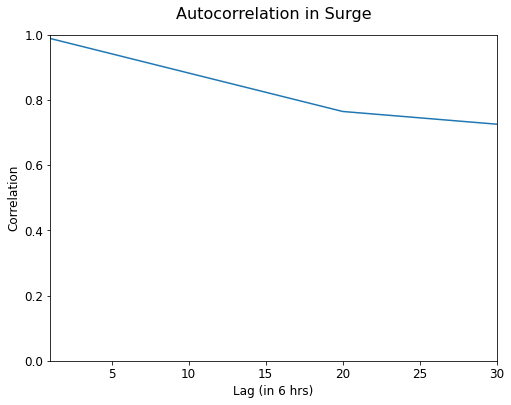

In [25]:
autcorrplt(data_cuxhaven['surge'], 30, "Surge")

## 3. Multi-Layer Perceptron (MLP) 
<a class="anchor" id="mlp"></a>

### MLP Sequential Model (Building a MLP model, Training the model, Model evaluation and Plotting the results) 
<a class="anchor" id="mlp2"></a>

In [26]:
# build a function for implementing MLP Sequential Model 

def mlp_seq(x_norm_train, x_norm_test, y_train, y_test):
    """
    Builds mlp, trains and tests it
    """
    # simple model
    model = Sequential()
    model.add(Dropout(0.2, input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation = 'sigmoid',\
                    input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation='sigmoid'))
    model.add(BatchNormalization())
    # model.add(Dense(180, activation='relu'))
    model.add(Dense(1))
    
    # training model
    model.compile(loss = 'mean_squared_error', optimizer = 'adagrad', \
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    history = model.fit(x_norm_train, y_train['surge'], epochs = 50, \
              batch_size = 10, verbose = 1, validation_split=0.20)
    
    testPredict = model.predict(x_norm_test)
    
    # prepare the data for plotting
    y = y_test[:]
    y.reset_index(inplace=True)
    y.drop(['index'], axis = 1, inplace=True) 
    
    # model evaluation
    print()
    print("mse = ", mean_squared_error(y_test['surge'], testPredict))
    print("mae = ", mean_absolute_error(y_test['surge'], testPredict))
    print("r2_score = ", r2_score(y_test['surge'], testPredict))

    print()
    
    # plotting 
    sns.set_context('notebook', font_scale= 1.5)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test['date'], y['surge'], color = 'blue')
    plt.plot(y_test['date'],testPredict, color= 'red')
    plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel('Surge Height (m)')
    plt.title("Observed vs. Predicted Storm Surge Height", fontsize=20, y=1.03)
    plt.savefig("1 mlp observed vs predicted surge height.png", dpi=300)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y_test['surge'], testPredict, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.show()

    # list all the data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('MLP Model Accuracy', fontsize=18, y=1.03)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig("2 mlp model accuracy.png", dpi=300)
    plt.show()

    # summarize history for loss
    plt.figure(figsize = (12, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MLP Model Loss', fontsize=18, y=1.03)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig("3 mlp model loss.png", dpi=300)
    plt.show()
    return testPredict

Epoch 1/50
374/374 [==============================] - 1s 2ms/step - loss: 0.2889 - mean_squared_error: 0.2889 - mean_absolute_error: 0.4118 - val_loss: 0.1117 - val_mean_squared_error: 0.1117 - val_mean_absolute_error: 0.2340
Epoch 2/50
374/374 [==============================] - 1s 2ms/step - loss: 0.1447 - mean_squared_error: 0.1447 - mean_absolute_error: 0.2940 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1775
Epoch 3/50
374/374 [==============================] - 1s 1ms/step - loss: 0.1239 - mean_squared_error: 0.1239 - mean_absolute_error: 0.2705 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1720
Epoch 4/50
374/374 [==============================] - 0s 1ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - mean_absolute_error: 0.2469 - val_loss: 0.0561 - val_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.1660
Epoch 5/50
374/374 [==============================] - 1s 1ms/step - loss: 0.0966 - mean_squared_

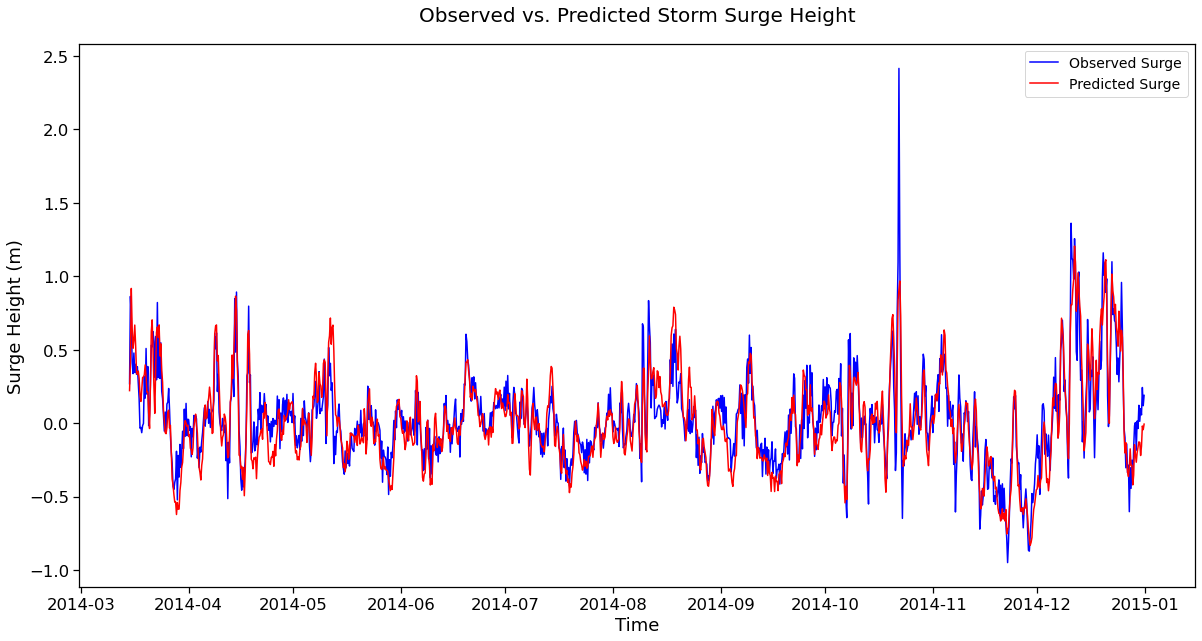

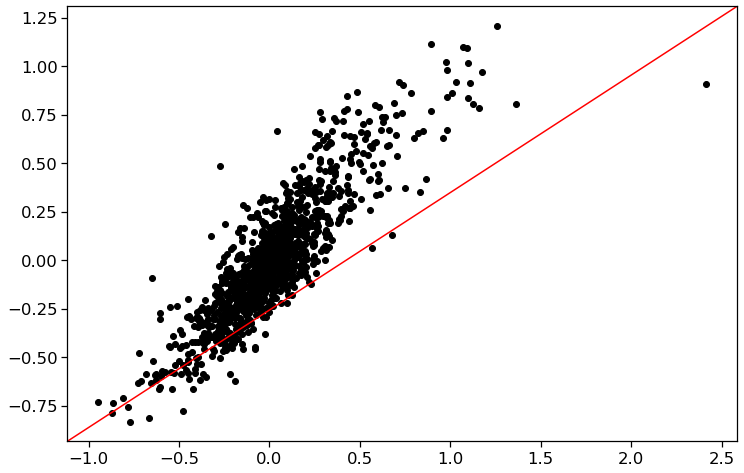

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


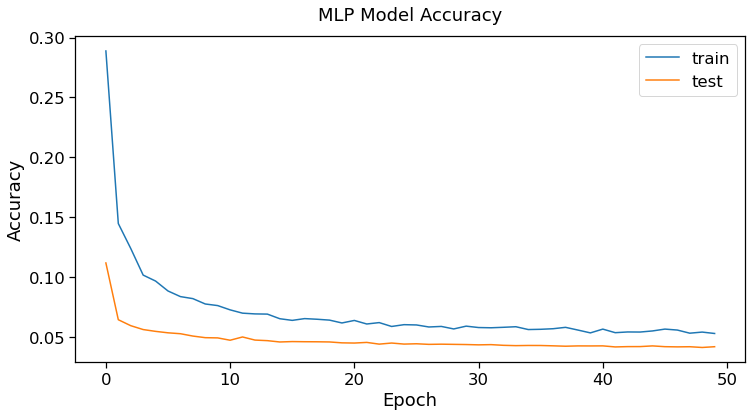

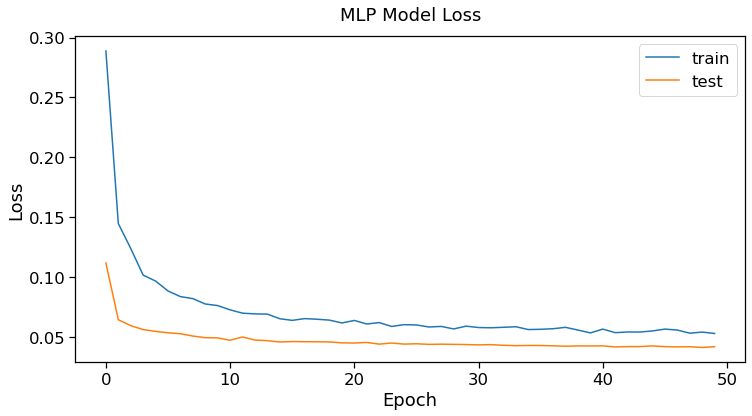

array([[ 0.22172497],
       [ 0.42089543],
       [ 0.9175895 ],
       ...,
       [-0.01925883],
       [-0.0442932 ],
       [-0.00633537]], dtype=float32)

In [27]:
mlp_seq(x_norm_train, x_norm_test, y_train, y_test)

### MLP Hyperparameter Tuning 
<a class="anchor" id="mlp3"></a>

In [39]:
x_norm_train = np.asarray(x_norm_train).astype(np.int)
x_norm_test = np.asarray(x_norm_train).astype(np.int)

y_train2 = y_train.drop(['date'], axis=1)
y_test2 = y_test.drop(['date'], axis=1)

y_train2 = np.asarray(y_train2).astype(np.int)
y_test2 = np.asarray(y_test2).astype(np.int)

In [48]:
# creating a function for MLP hyper parameters tuning

def mlp_tune():
    
    def create_model(layers, activation, optimizer):
        model = Sequential()
        for i, nodes in enumerate(layers):
            if i==0:
                model.add(Dense(nodes, input_dim = x_norm_train.shape[1]))
                model.add(Activation(activation))
            else:
                model.add(Dense(nodes))
                model.add(Activation(activation))
        model.add(Dense(1, activation = 'linear')) # Note: no activation beyond this point
        
        model.compile(optimizer = optimizer, loss='mse')
        # optimizers.Adam(learning_rate = rate, beta_1 = 0.9, \
        #                       beta_2 = 0.999, amsgrad=False)
        return model
    
    model = KerasRegressor(build_fn = create_model, verbose=1)

    # specifying layer architecture
    optimizer = ['adam', 'rmsprop', 'sgd','adagrad', 'adadelta'] 
    layers = [(3,), (10,), (30,), (10, 10), (10, 20), (20, 20), \
              (30, 30), (10, 10, 10), (20, 20, 20), \
                  (30, 30, 30), (10, 20, 30), (20, 20, 30)]
    activations = ['relu', 'tanh', 'sigmoid']
    param_grid = dict(layers=layers, optimizer = optimizer, activation=activations, \
                      batch_size = [10, 50, 100], epochs=[10, 50])
    grid = GridSearchCV(estimator = model, param_grid = param_grid,\
                        scoring='neg_mean_squared_error')
    
    
    grid_result = grid.fit(x_norm_train, y_train['surge'])
    
    [grid_result.best_score_, grid_result.best_params_]
    
    testPredict = grid.predict(x_norm_test)
    
    # model evaluation
#     print()
#     print(mean_squared_error(y_test2, testPredict))
#     print()
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
   
    
    # prepare data for plotting
    y = y_test[:]
    y.reset_index(inplace=True)
    y.drop(['index'], axis = 1, inplace=True) 
    
    # plotting the results
    sns.set_context('notebook', font_scale= 1.5)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test['date'], y['surge'], color='blue')
    plt.plot(y_test['date'], testPredict, color= 'red')
    plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14)
    plt.xlabel('Time')
    plt.ylabel('Surge Height (m)')
    plt.title("Observed vs. Predicted Storm Surge Height", fontsize=20, y=1.03)
    plt.savefig("6 mlp observed vs predicted surge height (after tuning).png", dpi=300)
    plt.show()
    

In [ ]:
mlp_tune()

## 4. Long Short-Term Memory Networks (LSTM) 
<a class="anchor" id="lstm"></a>

### Building LSTM model, Data preparation, Training the model, Model evaluation and Plotting the results 
<a class="anchor" id="lstm2"></a>

In [30]:
# create a function for implementing LSTM model

def lstm (x_norm_train, x_norm_test, y_train, y_test):
    # defining the model
    model = Sequential()
    model.add(LSTM(94, activation='relu', input_shape = (1, x_norm_train.shape[1])))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam')
    
    # reshaping the data to 3D
    x_train_resh = x_norm_train.reshape(x_norm_train.shape[0], \
                                        1, x_norm_train.shape[1])
    x_test_resh = x_norm_test.reshape(x_norm_test.shape[0], \
                                      1, x_norm_test.shape[1])
    
    # fit the model
    history = model.fit(x_train_resh, y_train['surge'], epochs = 50, \
                            batch_size = 20, verbose = 1, validation_split=0.20)
    
    plt.figure(figsize = (12,8))
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'test')
    plt.legend(loc='best')
    plt.savefig("7 LSTM model.png", dpi=300)
    plt.show()
    
    res = model.predict(x_test_resh)
    
    # prepare the data for plotting
    y = y_test[:]
    y.reset_index(inplace=True)
    y.drop(['index'], axis = 1, inplace=True) 
    
    # model evaluation
    print()
    print("mse = ", mean_squared_error(y_test['surge'], res))
    print("mae = ", mean_absolute_error(y_test['surge'], res))
    print("r2_score = ", r2_score(y_test['surge'], res))

    print()
    
    # plotting the results
    sns.set_context('notebook', font_scale= 1.5)
    plt.figure(figsize=(20, 10))
    plt.plot(y_test['date'], y['surge'], color = 'blue')
    plt.plot(y_test['date'], res, color= 'red')
    plt.title(" Observed vs Predicted Storm Surge Height (LSTM)", fontsize=18, y=1.03)
    plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14, loc='best')
    plt.ylabel('Surge Height (m)')
    plt.savefig("8 LSTM observe vs predicted surge.png", dpi=300) 
    plt.show()
 
    # summarize history for loss
    plt.figure(figsize = (12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM Model Loss', fontsize=18, y=1.03)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig("9 LSTM model loss.png", dpi=300)
    plt.show()
    
    return res

Epoch 1/50
187/187 [==============================] - 1s 3ms/step - loss: 0.0403 - val_loss: 0.0448
Epoch 2/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0371
Epoch 3/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0395
Epoch 4/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0376
Epoch 5/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0188 - val_loss: 0.0344
Epoch 6/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0352
Epoch 7/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0466
Epoch 8/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0342
Epoch 9/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0351
Epoch 10/50
187/187 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0354

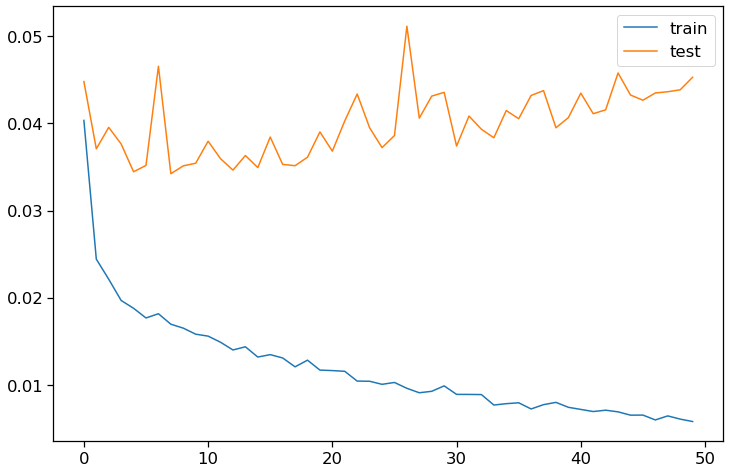


mse =  0.027366407314761594
mae =  0.12046443008823282
r2_score =  0.6987846741043695



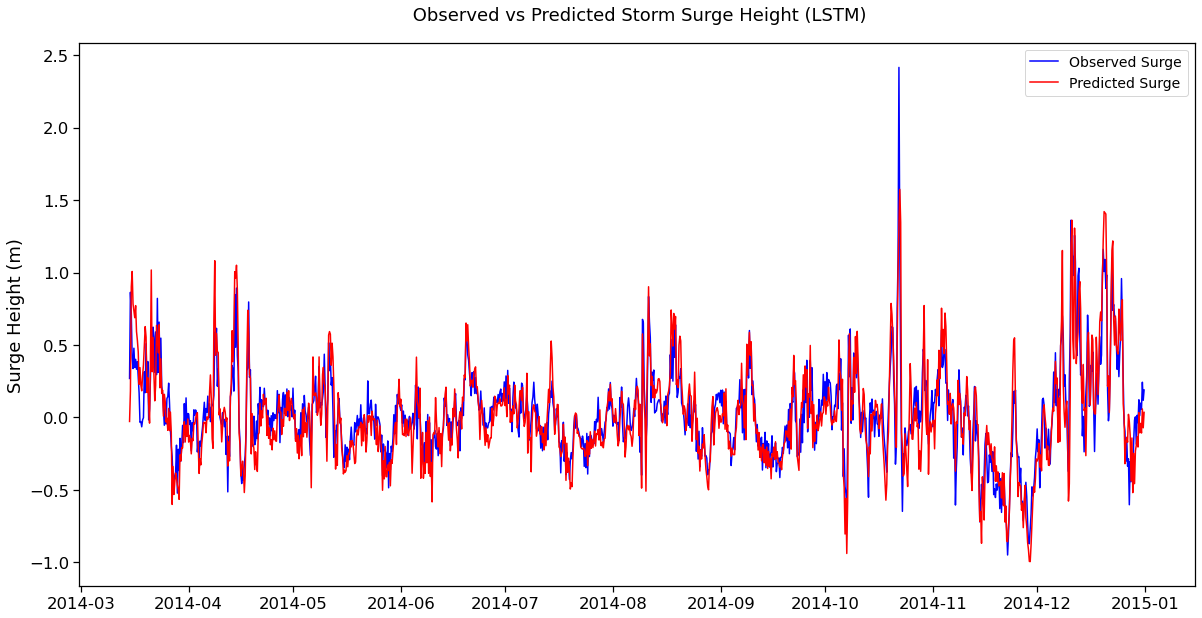

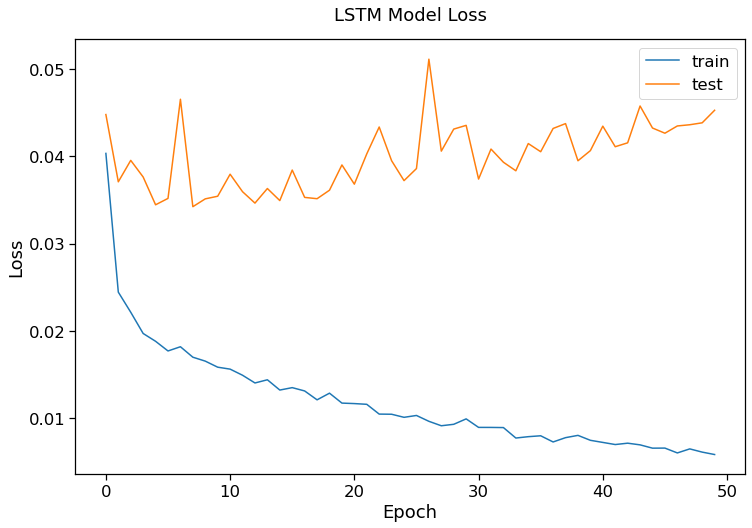

array([[-0.02787248],
       [ 0.18217611],
       [ 0.90172637],
       ...,
       [ 0.05835253],
       [-0.07161152],
       [ 0.03494701]], dtype=float32)

In [31]:
lstm (x_norm_train, x_norm_test, y_train, y_test)

## 5. Auto Regressive Integrated Moving Average (ARIMA) 
<a class="anchor" id="arima"></a>

In [32]:
# fit ARIMA model
model = ARIMA(y_train['surge'], order = (20, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  surge   No. Observations:                 4671
Model:                    ARMA(20, 0)   Log Likelihood                 781.940
Method:                       css-mle   S.D. of innovations              0.205
Date:                Wed, 14 Apr 2021   AIC                          -1519.881
Time:                        20:10:59   BIC                          -1378.000
Sample:                             0   HQIC                         -1469.982
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0003      0.019     -0.017      0.986      -0.037       0.037
ar.L1.surge      0.6866      0.015     46.937      0.000       0.658       0.715
ar.L2.surge      0.3489      0.018     19.66

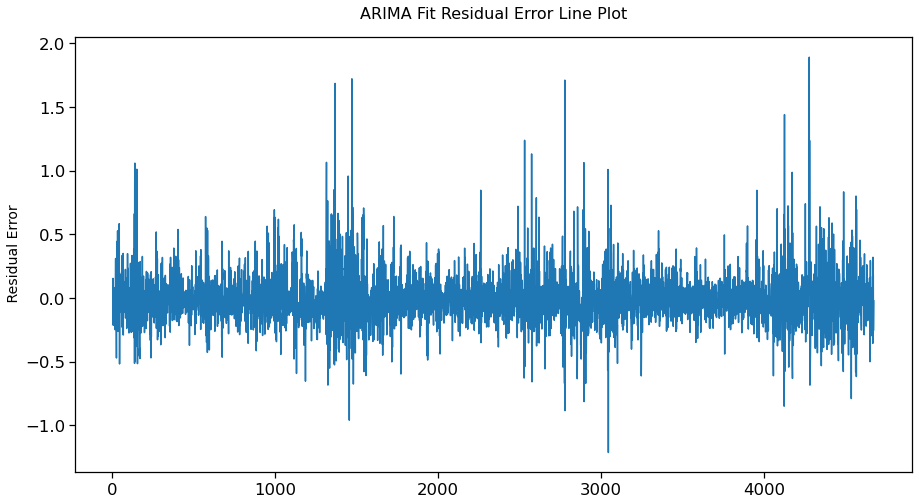

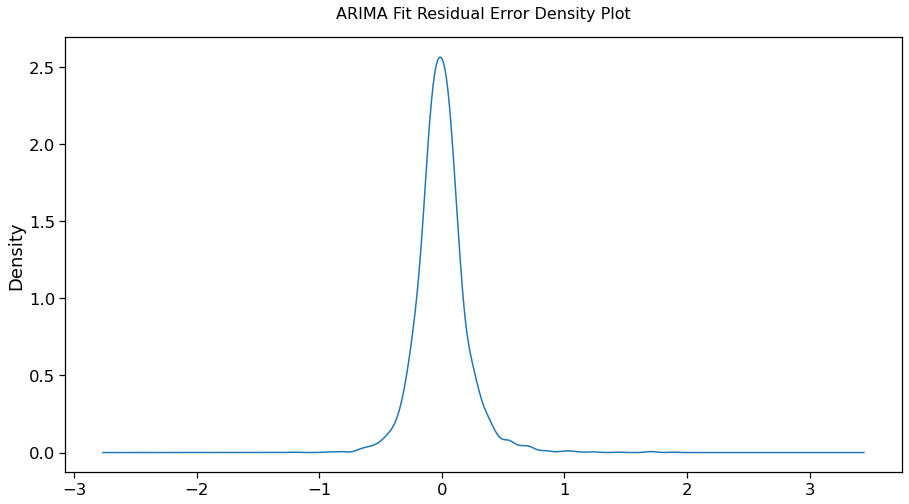

                 0
count  4671.000000
mean      0.000044
std       0.204677
min      -1.213636
25%      -0.111577
50%      -0.009844
75%       0.093332
max       1.891047


In [33]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

# line plot of residuals
residuals.plot(legend=None, figsize = (15, 8))
plt.ylabel(" Residual Error", fontsize=14)
plt.title("ARIMA Fit Residual Error Line Plot", fontsize=16, y=1.03)
plt.savefig("10 ARIMA Fit Residual Error Line Plot", dpi=300)
plt.show()

# density plot of residuals
residuals.plot(kind = 'kde', legend=None, figsize = (15, 8))
plt.title("ARIMA Fit Residual Error Density Plot", fontsize=16, y=1.03)
plt.savefig("11 ARIMA Fit Residual Error Density Plot", dpi=300)
plt.show()

print(residuals.describe())

The residual errors seem to fluctuate around a mean of zero and have a uniform variance. The density plot suggest normal distribution with mean zero. Overall, it seems to be a good fit.

In [34]:
# forecasting
history = [x for x in y_train['surge']]
predictions = [];

for t in y_test['surge'].index:
    model = ARIMA(history, order = (10, 0, 0))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    print(output)
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test['surge'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(y_test['surge'], predictions)

# model evaluation
print()
print("mse = ", mean_squared_error(y_test['surge'], predictions))
print("mae = ", mean_absolute_error(y_test['surge'], predictions))
print("r2_score = ", r2_score(y_test['surge'], predictions))

print()

print('Test MSE: %.3f' % error)

(array([-0.29736865]), array([0.20505246]), array([[-0.69926409,  0.10452679]]))
predicted=-0.297369, expected=0.269050
(array([0.05594658]), array([0.20519742]), array([[-0.34623298,  0.45812614]]))
predicted=0.055947, expected=0.863970
(array([0.80291337]), array([0.20551405]), array([[0.40011324, 1.2057135 ]]))
predicted=0.802913, expected=0.715220
(array([0.62761581]), array([0.20549605]), array([[0.22485095, 1.03038066]]))
predicted=0.627616, expected=0.411040
(array([0.17066044]), array([0.20549832]), array([[-0.23210886,  0.57342975]]))
predicted=0.170660, expected=0.337190
(array([0.21381906]), array([0.20549068]), array([[-0.18893528,  0.6165734 ]]))
predicted=0.213819, expected=0.477860
(array([0.32274037]), array([0.2055047]), array([[-0.08004144,  0.72552218]]))
predicted=0.322740, expected=0.344900
(array([0.37297638]), array([0.20548299]), array([[-0.02976287,  0.77571563]]))
predicted=0.372976, expected=0.400990
(array([0.33050697]), array([0.20546143]), array([[-0.07219

(array([-0.03480438]), array([0.20482673]), array([[-0.4362574 ,  0.36664863]]))
predicted=-0.034804, expected=-0.022219
(array([-0.05415014]), array([0.20480521]), array([[-0.45556099,  0.3472607 ]]))
predicted=-0.054150, expected=-0.229240
(array([-0.11884152]), array([0.20479938]), array([[-0.52024094,  0.28255789]]))
predicted=-0.118842, expected=-0.036346
(array([-0.12620978]), array([0.2047813]), array([[-0.52757375,  0.27515418]]))
predicted=-0.126210, expected=-0.091882
(array([0.02679743]), array([0.20476033]), array([[-0.37452543,  0.42812029]]))
predicted=0.026797, expected=0.052576
(array([-0.01849089]), array([0.20473909]), array([[-0.41977214,  0.38279036]]))
predicted=-0.018491, expected=0.016277
(array([0.06149177]), array([0.20471815]), array([[-0.33974843,  0.46273197]]))
predicted=0.061492, expected=0.051305
(array([0.00561388]), array([0.20469664]), array([[-0.39558417,  0.40681192]]))
predicted=0.005614, expected=0.029210
(array([0.01649475]), array([0.20467538]), 

(array([0.37618884]), array([0.20444366]), array([[-0.02451336,  0.77689105]]))
predicted=0.376189, expected=0.328780
(array([0.02168925]), array([0.20442355]), array([[-0.37897355,  0.42235205]]))
predicted=0.021689, expected=-0.202770
(array([-0.01008341]), array([0.20442782]), array([[-0.41075458,  0.39058775]]))
predicted=-0.010083, expected=-0.198020
(array([-0.28361071]), array([0.20442449]), array([[-0.68427534,  0.11705392]]))
predicted=-0.283611, expected=-0.120530
(array([-0.00698745]), array([0.20441674]), array([[-0.40763689,  0.39366199]]))
predicted=-0.006987, expected=0.008423
(array([0.07414081]), array([0.20439563]), array([[-0.32646726,  0.47474888]]))
predicted=0.074141, expected=-0.188720
(array([-0.12478897]), array([0.20440943]), array([[-0.5254241 ,  0.27584615]]))
predicted=-0.124789, expected=-0.158300
(array([-0.16165527]), array([0.20438878]), array([[-0.56224992,  0.23893938]]))
predicted=-0.161655, expected=-0.025143
(array([-0.02301037]), array([0.20437701

(array([-0.0666623]), array([0.20335751]), array([[-0.46523569,  0.3319111 ]]))
predicted=-0.066662, expected=-0.262020
(array([-0.2646275]), array([0.20335589]), array([[-0.66319771,  0.13394272]]))
predicted=-0.264627, expected=-0.179280
(array([-0.14055849]), array([0.20333873]), array([[-0.53909507,  0.2579781 ]]))
predicted=-0.140558, expected=0.089865
(array([0.07422617]), array([0.20334463]), array([[-0.32432198,  0.47277431]]))
predicted=0.074226, expected=0.101440
(array([0.14024845]), array([0.20332418]), array([[-0.25825962,  0.53875651]]))
predicted=0.140248, expected=0.116460
(array([0.06656928]), array([0.20330365]), array([[-0.33189854,  0.4650371 ]]))
predicted=0.066569, expected=0.213960
(array([0.14366967]), array([0.20329376]), array([[-0.25477878,  0.54211813]]))
predicted=0.143670, expected=0.284300
(array([0.21511685]), array([0.2032829]), array([[-0.18331032,  0.61354402]]))
predicted=0.215117, expected=0.032996
(array([0.04881988]), array([0.20327878]), array([[

(array([-0.09751544]), array([0.20255706]), array([[-0.49451998,  0.29948909]]))
predicted=-0.097515, expected=0.091118
(array([0.09901054]), array([0.20255434]), array([[-0.29798866,  0.49600975]]))
predicted=0.099011, expected=0.119570
(array([0.09557768]), array([0.20253409]), array([[-0.30138184,  0.49253719]]))
predicted=0.095578, expected=0.000179
(array([-0.00365397]), array([0.20251816]), array([[-0.40058228,  0.39327434]]))
predicted=-0.003654, expected=0.008277
(array([0.01501652]), array([0.20249779]), array([[-0.38187185,  0.41190489]]))
predicted=0.015017, expected=-0.027667
(array([-0.01617594]), array([0.20247825]), array([[-0.41302602,  0.38067415]]))
predicted=-0.016176, expected=-0.149590
(array([-0.12235705]), array([0.20246668]), array([[-0.51918445,  0.27447034]]))
predicted=-0.122357, expected=0.090862
(array([0.03831698]), array([0.20246889]), array([[-0.35851474,  0.43514871]]))
predicted=0.038317, expected=-0.054788
(array([0.06237352]), array([0.20245278]), ar

(array([-0.14969208]), array([0.20163444]), array([[-0.54488832,  0.24550415]]))
predicted=-0.149692, expected=-0.371740
(array([-0.18727955]), array([0.20163868]), array([[-0.5824841,  0.207925 ]]))
predicted=-0.187280, expected=-0.153970
(array([-0.25140266]), array([0.20161914]), array([[-0.64656891,  0.14376359]]))
predicted=-0.251403, expected=-0.346140
(array([-0.15831316]), array([0.20160348]), array([[-0.55344872,  0.23682239]]))
predicted=-0.158313, expected=-0.147130
(array([-0.21330061]), array([0.20158346]), array([[-0.60839694,  0.18179572]]))
predicted=-0.213301, expected=-0.138440
(array([-0.05110292]), array([0.20156616]), array([[-0.44616534,  0.3439595 ]]))
predicted=-0.051103, expected=-0.089167
(array([-0.09104536]), array([0.20154681]), array([[-0.48606985,  0.30397914]]))
predicted=-0.091045, expected=-0.202160
(array([-0.17234737]), array([0.20153284]), array([[-0.56734449,  0.22264974]]))
predicted=-0.172347, expected=-0.218280
(array([-0.19591483]), array([0.20

(array([-0.00060725]), array([0.20060544]), array([[-0.39378668,  0.39257218]]))
predicted=-0.000607, expected=0.070569
(array([0.02518815]), array([0.2005882]), array([[-0.36795749,  0.41833379]]))
predicted=0.025188, expected=-0.026139
(array([0.01871179]), array([0.20056977]), array([[-0.37439774,  0.41182132]]))
predicted=0.018712, expected=0.076242
(array([0.00432354]), array([0.20055169]), array([[-0.38875055,  0.39739762]]))
predicted=0.004324, expected=0.050019
(array([0.0812841]), array([0.20053301]), array([[-0.31175337,  0.47432157]]))
predicted=0.081284, expected=0.139710
(array([0.07382304]), array([0.20051498]), array([[-0.3191791 ,  0.46682518]]))
predicted=0.073823, expected=0.121060
(array([0.12372672]), array([0.20049638]), array([[-0.26923897,  0.51669242]]))
predicted=0.123727, expected=0.098572
(array([0.06966902]), array([0.20047701]), array([[-0.3232587 ,  0.46259674]]))
predicted=0.069669, expected=0.119550
(array([0.07909628]), array([0.20045855]), array([[-0.3

(array([0.12074186]), array([0.19952734]), array([[-0.27032455,  0.51180827]]))
predicted=0.120742, expected=0.138440
(array([0.13354205]), array([0.19950815]), array([[-0.25748673,  0.52457084]]))
predicted=0.133542, expected=0.250890
(array([0.15514248]), array([0.19949549]), array([[-0.2358615 ,  0.54614646]]))
predicted=0.155142, expected=0.099306
(array([0.10918972]), array([0.19947767]), array([[-0.28177934,  0.50015877]]))
predicted=0.109190, expected=0.059667
(array([0.00385548]), array([0.19945953]), array([[-0.38707802,  0.39478898]]))
predicted=0.003855, expected=-0.088962
(array([-0.03264533]), array([0.19944439]), array([[-0.42354915,  0.35825849]]))
predicted=-0.032645, expected=-0.045995
(array([-0.0653746]), array([0.19942516]), array([[-0.45624072,  0.32549153]]))
predicted=-0.065375, expected=0.060560
(array([0.07250021]), array([0.19941354]), array([[-0.31834315,  0.46334357]]))
predicted=0.072500, expected=0.006869
(array([0.05220754]), array([0.19939633]), array([[

(array([0.10983854]), array([0.19847421]), array([[-0.27916376,  0.49884084]]))
predicted=0.109839, expected=0.083453
(array([0.14912676]), array([0.19845555]), array([[-0.23983898,  0.5380925 ]]))
predicted=0.149127, expected=0.065046
(array([-0.01537863]), array([0.19843998]), array([[-0.40431384,  0.37355658]]))
predicted=-0.015379, expected=-0.060154
(array([-0.01179073]), array([0.19842196]), array([[-0.40069064,  0.37710917]]))
predicted=-0.011791, expected=0.015359
(array([-0.00959342]), array([0.19840335]), array([[-0.39845683,  0.37926999]]))
predicted=-0.009593, expected=-0.004681
(array([0.02734604]), array([0.19838439]), array([[-0.36148022,  0.41617229]]))
predicted=0.027346, expected=-0.038187
(array([-0.01780584]), array([0.19836749]), array([[-0.40659898,  0.3709873 ]]))
predicted=-0.017806, expected=-0.036777
(array([-0.03571309]), array([0.19834871]), array([[-0.42446941,  0.35304324]]))
predicted=-0.035713, expected=-0.045945
(array([-0.02562764]), array([0.19832981]

(array([0.27776139]), array([0.19836632]), array([[-0.11102945,  0.66655223]]))
predicted=0.277761, expected=0.270640
(array([0.31933576]), array([0.19834761]), array([[-0.06941841,  0.70808993]]))
predicted=0.319336, expected=0.539400
(array([0.30683549]), array([0.19835189]), array([[-0.08192707,  0.69559806]]))
predicted=0.306835, expected=0.250630
(array([0.31811373]), array([0.19833467]), array([[-0.07061509,  0.70684254]]))
predicted=0.318114, expected=0.606890
(array([0.33192688]), array([0.19835557]), array([[-0.05684288,  0.72069665]]))
predicted=0.331927, expected=0.414550
(array([0.4921995]), array([0.19834009]), array([[0.10346007, 0.88093893]]))
predicted=0.492200, expected=0.639450
(array([0.39993468]), array([0.19833166]), array([[0.01121178, 0.78865758]]))
predicted=0.399935, expected=0.278520
(array([0.34724476]), array([0.19831996]), array([[-0.04145521,  0.73594473]]))
predicted=0.347245, expected=0.137810
(array([0.03290202]), array([0.1983221]), array([[-0.35580215

(array([-0.10042469]), array([0.1974703]), array([[-0.48745936,  0.28660998]]))
predicted=-0.100425, expected=-0.332080
(array([-0.22208594]), array([0.1974772]), array([[-0.60913414,  0.16496226]]))
predicted=-0.222086, expected=-0.242930
(array([-0.26495087]), array([0.197459]), array([[-0.6519634 ,  0.12206165]]))
predicted=-0.264951, expected=-0.210820
(array([-0.11547803]), array([0.19744198]), array([[-0.50245721,  0.27150114]]))
predicted=-0.115478, expected=-0.138690
(array([-0.12638376]), array([0.19742384]), array([[-0.51332738,  0.26055987]]))
predicted=-0.126384, expected=-0.224140
(array([-0.15196405]), array([0.19740996]), array([[-0.53888045,  0.23495236]]))
predicted=-0.151964, expected=-0.093847
(array([-0.12170802]), array([0.19739317]), array([[-0.50859151,  0.26517548]]))
predicted=-0.121708, expected=0.062807
(array([0.0489731]), array([0.19739084]), array([[-0.33790584,  0.43585205]]))
predicted=0.048973, expected=0.069883
(array([0.06707058]), array([0.19737267])

(array([-0.08341484]), array([0.19670651]), array([[-0.4689525 ,  0.30212283]]))
predicted=-0.083415, expected=-0.068940
(array([0.08884008]), array([0.1966885]), array([[-0.2966623 ,  0.47434245]]))
predicted=0.088840, expected=0.116120
(array([-0.02946055]), array([0.19667075]), array([[-0.41492813,  0.35600704]]))
predicted=-0.029461, expected=0.104090
(array([0.14208342]), array([0.196661]), array([[-0.24336505,  0.52753189]]))
predicted=0.142083, expected=0.335940
(array([0.2257907]), array([0.19666046]), array([[-0.15965672,  0.61123813]]))
predicted=0.225791, expected=0.305110
(array([0.26602494]), array([0.19664531]), array([[-0.1193928 ,  0.65144267]]))
predicted=0.266025, expected=-0.023458
(array([-0.00125216]), array([0.19666638]), array([[-0.38671117,  0.38420686]]))
predicted=-0.001252, expected=-0.039319
(array([-0.12286488]), array([0.19664897]), array([[-0.50828979,  0.26256002]]))
predicted=-0.122865, expected=-0.269850
(array([-0.12758025]), array([0.19664097]), arra

(array([0.2297128]), array([0.19643202]), array([[-0.15528688,  0.61471248]]))
predicted=0.229713, expected=-0.040225
(array([0.15045632]), array([0.19644769]), array([[-0.23457407,  0.53548671]]))
predicted=0.150456, expected=0.203950
(array([-0.15555274]), array([0.19643115]), array([[-0.54055072,  0.22944524]]))
predicted=-0.155553, expected=-0.017694
(array([0.19925249]), array([0.19642207]), array([[-0.1857277 ,  0.58423267]]))
predicted=0.199252, expected=0.444780
(array([0.25865955]), array([0.19643193]), array([[-0.12633997,  0.64365906]]))
predicted=0.258660, expected=0.311150
(array([0.3895628]), array([0.19641536]), array([[0.00459577, 0.77452982]]))
predicted=0.389563, expected=0.415210
(array([0.25605902]), array([0.19639782]), array([[-0.12887364,  0.64099168]]))
predicted=0.256059, expected=0.273660
(array([0.23920476]), array([0.19638014]), array([[-0.14569324,  0.62410275]]))
predicted=0.239205, expected=0.460340
(array([0.31753679]), array([0.19638486]), array([[-0.06

(array([-0.04114255]), array([0.19791956]), array([[-0.42905775,  0.34677265]]))
predicted=-0.041143, expected=-0.113710
(array([-0.09265826]), array([0.19790418]), array([[-0.48054332,  0.2952268 ]]))
predicted=-0.092658, expected=-0.049253
(array([-0.08386159]), array([0.19788727]), array([[-0.47171351,  0.30399034]]))
predicted=-0.083862, expected=-0.014404
(array([0.0086023]), array([0.19787171]), array([[-0.37921912,  0.39642372]]))
predicted=0.008602, expected=0.093815
(array([0.05933595]), array([0.19785725]), array([[-0.32845713,  0.44712902]]))
predicted=0.059336, expected=0.203540
(array([0.16748888]), array([0.19784892]), array([[-0.22028789,  0.55526564]]))
predicted=0.167489, expected=0.081717
(array([0.08469453]), array([0.19783452]), array([[-0.303054  ,  0.47244306]]))
predicted=0.084695, expected=0.214050
(array([0.09244267]), array([0.19782436]), array([[-0.29528595,  0.48017129]]))
predicted=0.092443, expected=-0.008081
(array([0.07147506]), array([0.1978112]), array

(array([-0.30545375]), array([0.19734915]), array([[-0.69225099,  0.08134348]]))
predicted=-0.305454, expected=-0.390630
(array([-0.29256944]), array([0.19733491]), array([[-0.67933876,  0.09419988]]))
predicted=-0.292569, expected=-0.111030
(array([-0.10639431]), array([0.19733222]), array([[-0.49315835,  0.28036973]]))
predicted=-0.106394, expected=0.023364
(array([0.09958329]), array([0.19732229]), array([[-0.28716129,  0.48632787]]))
predicted=0.099583, expected=0.213530
(array([0.13142356]), array([0.19731062]), array([[-0.25529816,  0.51814528]]))
predicted=0.131424, expected=-0.162460
(array([-0.08370759]), array([0.19733188]), array([[-0.47047096,  0.30305579]]))
predicted=-0.083708, expected=-0.023173
(array([-0.18292778]), array([0.19731605]), array([[-0.56966013,  0.20380456]]))
predicted=-0.182928, expected=-0.097675
(array([0.00988844]), array([0.19730184]), array([[-0.37681606,  0.39659294]]))
predicted=0.009888, expected=-0.151830
(array([-0.15250611]), array([0.1972961]

(array([-0.61879615]), array([0.19703089]), array([[-1.00496959, -0.2326227 ]]))
predicted=-0.618796, expected=-0.667150
(array([-0.52566849]), array([0.19701466]), array([[-0.91181013, -0.13952684]]))
predicted=-0.525668, expected=-0.479130
(array([-0.41378323]), array([0.19699838]), array([[-0.79989295, -0.02767351]]))
predicted=-0.413783, expected=-0.541010
(array([-0.431579]), array([0.1969883]), array([[-0.81766897, -0.04548904]]))
predicted=-0.431579, expected=-0.490310
(array([-0.48706134]), array([0.19697258]), array([[-0.87312049, -0.10100218]]))
predicted=-0.487061, expected=-0.412540
(array([-0.34938762]), array([0.19695781]), array([[-0.73541783,  0.0366426 ]]))
predicted=-0.349388, expected=-0.275790
(array([-0.25654061]), array([0.19694298]), array([[-0.64254176,  0.12946054]]))
predicted=-0.256541, expected=-0.208890
(array([-0.18292677]), array([0.19692676]), array([[-0.56889614,  0.20304259]]))
predicted=-0.182927, expected=-0.079246
(array([-0.09742011]), array([0.196

(array([0.34148188]), array([0.19776289]), array([[-0.04612627,  0.72909002]]))
predicted=0.341482, expected=0.318050
(array([0.31666427]), array([0.19774602]), array([[-0.07091082,  0.70423935]]))
predicted=0.316664, expected=0.451790
(array([0.35447861]), array([0.19773687]), array([[-0.03307853,  0.74203576]]))
predicted=0.354479, expected=0.071070
(array([0.15295453]), array([0.19775483]), array([[-0.23463782,  0.54054687]]))
predicted=0.152955, expected=-0.235240
(array([-0.30656484]), array([0.19780343]), array([[-0.69425243,  0.08112276]]))
predicted=-0.306565, expected=0.050079
(array([0.01511936]), array([0.19784175]), array([[-0.37264334,  0.40288206]]))
predicted=0.015119, expected=0.163700
(array([0.28231157]), array([0.19783425]), array([[-0.10543643,  0.67005958]]))
predicted=0.282312, expected=0.307570
(array([0.2135414]), array([0.19781743]), array([[-0.17417363,  0.60125643]]))
predicted=0.213541, expected=0.091614
(array([0.15597206]), array([0.19780682]), array([[-0.

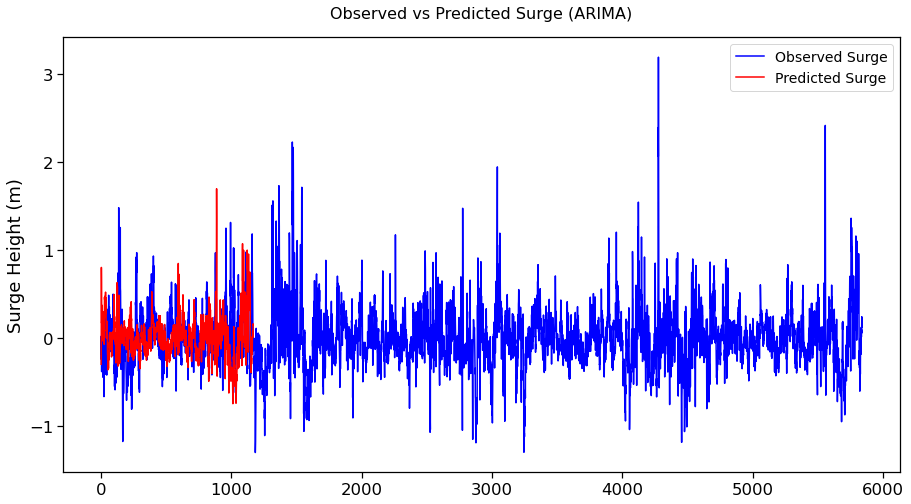

In [37]:
# visualization
sns.set_context('notebook', font_scale= 1.5)

plt.figure(figsize=(15, 8))
plt.plot(history, color='blue')
plt.plot(predictions, color= 'red')
plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14, loc='best')
plt.ylabel('Surge Height (m)')
plt.title('Observed vs Predicted Surge (ARIMA)', fontsize=16, y=1.03)

plt.savefig("12 Observed vs Predicted Surge (ARIMA).png", dpi=300)
plt.show()

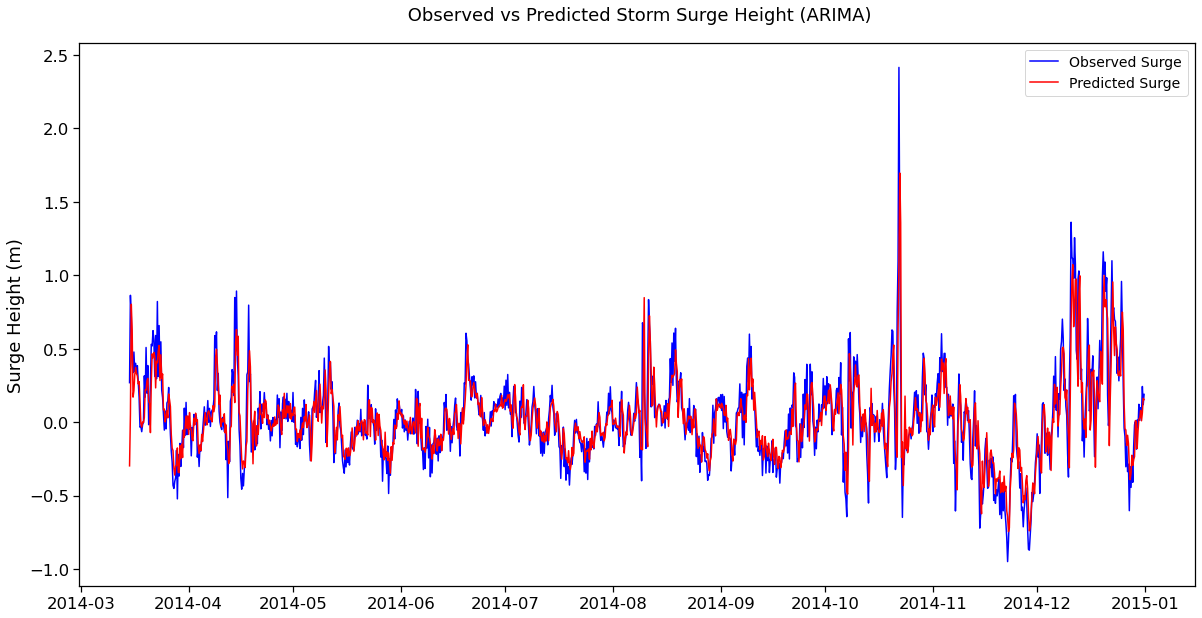

In [38]:
y = y_test[:]
y.reset_index(inplace=True)
y.drop(['index'], axis = 1, inplace=True) 

sns.set_context('notebook', font_scale= 1.5)
plt.figure(figsize=(20, 10))
plt.plot(y_test['date'], y['surge'], color = 'blue')
plt.plot(y_test['date'], predictions, color= 'red')
plt.title(" Observed vs Predicted Storm Surge Height (ARIMA)", fontsize=18, y=1.03)
plt.legend(['Observed Surge', 'Predicted Surge'], fontsize = 14, loc='best')
plt.ylabel('Surge Height (m)')
plt.savefig("13 ARIMA observe vs predicted surge.png", dpi=300) 
plt.show()

## 6. Convolutional Neural Networks (CNN) 
<a class="anchor" id="cnn"></a>

In [91]:
x_cnn = [];
for i in range(x.shape[0]):
    x_seq = np.array(x.iloc[i, :]).reshape(1, x.shape[1])
    x_cnn.append(x_seq)

n_steps = 186 
n_features = 1

x_trn = np.array(x.copy())
x_trn = x_trn.reshape(x_trn.shape[0], 1, x_trn.shape[1])

model = Sequential() 
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', \
                 input_shape=(5839, 186)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


model.fit(x_trn, surge['surge'], epochs=1000, verbose=0)